# TensorFlow Example Transformer

This notebook is a first implementation. But this time we use feature scaling...

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 
import json
import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

In [2]:
sys.path.insert(0,"./..")

In [3]:
from src.config import *
INPUT_SIZE = MAX_SEQUENCES
N_COLS = N_LANDMARKS

# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250

INPUT_SIZE = 32

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 160
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237





In [4]:
TRAIN_MODEL = True
PREPROCESSING = True

In [5]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0 = np.arange(502, 512)
LANDMARK_IDXS0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 42, N_COLS: 92


In [6]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 82


# Get Training Data

In [7]:
df_train = pd.read_csv(os.path.join(ROOT_PATH,RAW_DATA_DIR,TRAIN_CSV_FILE))
path_json = os.path.join(ROOT_PATH, RAW_DATA_DIR, MAP_JSON_FILE)

label_dict = json.load(open(path_json))
label_dict_inv = {v: k for k, v in label_dict.items()}
df_train["target"] = df_train.sign.map(label_dict)



N_SAMPLES = len(df_train)

In [8]:
df_train.shape

(94477, 5)

In [9]:
N_SAMPLES

94477

In [10]:
df_train.head()

,path,participant_id,sequence_id,sign,target
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [11]:
# Get complete file path to file
def get_file_path(path):
    return os.path.join(ROOT_PATH,RAW_DATA_DIR,path)

df_train['file_path'] = df_train['path'].apply(get_file_path)

In [12]:
df_train.head()

,path,participant_id,sequence_id,sign,target,file_path
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,C:\Users\fs.GUNDP\Python\CAS-AML-FINAL-PROJECT...
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,C:\Users\fs.GUNDP\Python\CAS-AML-FINAL-PROJECT...
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,C:\Users\fs.GUNDP\Python\CAS-AML-FINAL-PROJECT...
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,C:\Users\fs.GUNDP\Python\CAS-AML-FINAL-PROJECT...
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,C:\Users\fs.GUNDP\Python\CAS-AML-FINAL-PROJECT...


In [13]:
#load first file
arr_in = pd.read_parquet(df_train.iloc[0].file_path)

In [14]:
arr_in.shape

(12489, 7)

# Preprocessing Layer

In [15]:

TOTAL_LANDMARKS = 543
N_DIMS = 3

In [16]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Filter Out Frames With Empty Hand Data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, HAND_IDXS0, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 

        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        data = tf.gather(data, LANDMARK_IDXS0, axis=1)
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [17]:
#load a sample parquet file
pq_path = os.path.join(ROOT_PATH,RAW_DATA_DIR,r"train_landmark_files\2044\635217.parquet")
df_parquet_raw = pd.read_parquet(pq_path)

In [18]:
df_parquet_raw[COLUMNS_TO_USE + ["z"]].values.shape

(3801, 3)

In [19]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [20]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

In [21]:
data = load_relevant_data_subset(pq_path=pq_path)

In [22]:
data.shape

(7, 543, 3)

In [23]:
prep_data = get_data(pq_path)

In [24]:
prep_data[0].shape

TensorShape([32, 92, 3])

In [25]:
prep_data[1].shape

TensorShape([32])

In [26]:
prep_data[1]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.], dtype=float32)>

In [27]:
prep_data[0];

In [28]:
mask = tf.cast(tf.math.not_equal(prep_data[1], -1), tf.float32)

In [29]:
mask

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

## Get DataSet

In [30]:
# Get the full dataset
def get_x_y(sample = 100000):
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(df_train.sample(min(sample, len(df_train)))[['file_path', 'target']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    return X, y, NON_EMPTY_FRAME_IDXS

In [32]:
PREPROCESSING

True

In [33]:
if PREPROCESS_DATA:
    X,y,Non_empty_Frame_idxs = get_x_y(sample = 10000000)
else:
    X = np.load("X.npy")
    
    y = np.load("y.npy")
    
    Non_empty_Frame_idxs = np.load("NON_EMPTY_FRAME_IDXS.npy")

In [34]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [35]:
dummy_dataset = get_train_batch_all_signs(X, y, Non_empty_Frame_idxs)
X_batch, y_batch = next(dummy_dataset)

In [36]:
X_batch["frames"].shape

(1000, 32, 92, 3)

# Transformer Model

In [37]:
#Model Config
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 384

# Transformer
NUM_BLOCKS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

In [38]:
N_COLS

92

In [39]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [40]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2
    
        return x

# Scaling of Features

## Lips

Calculate mean values of Lips

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.83it/s]


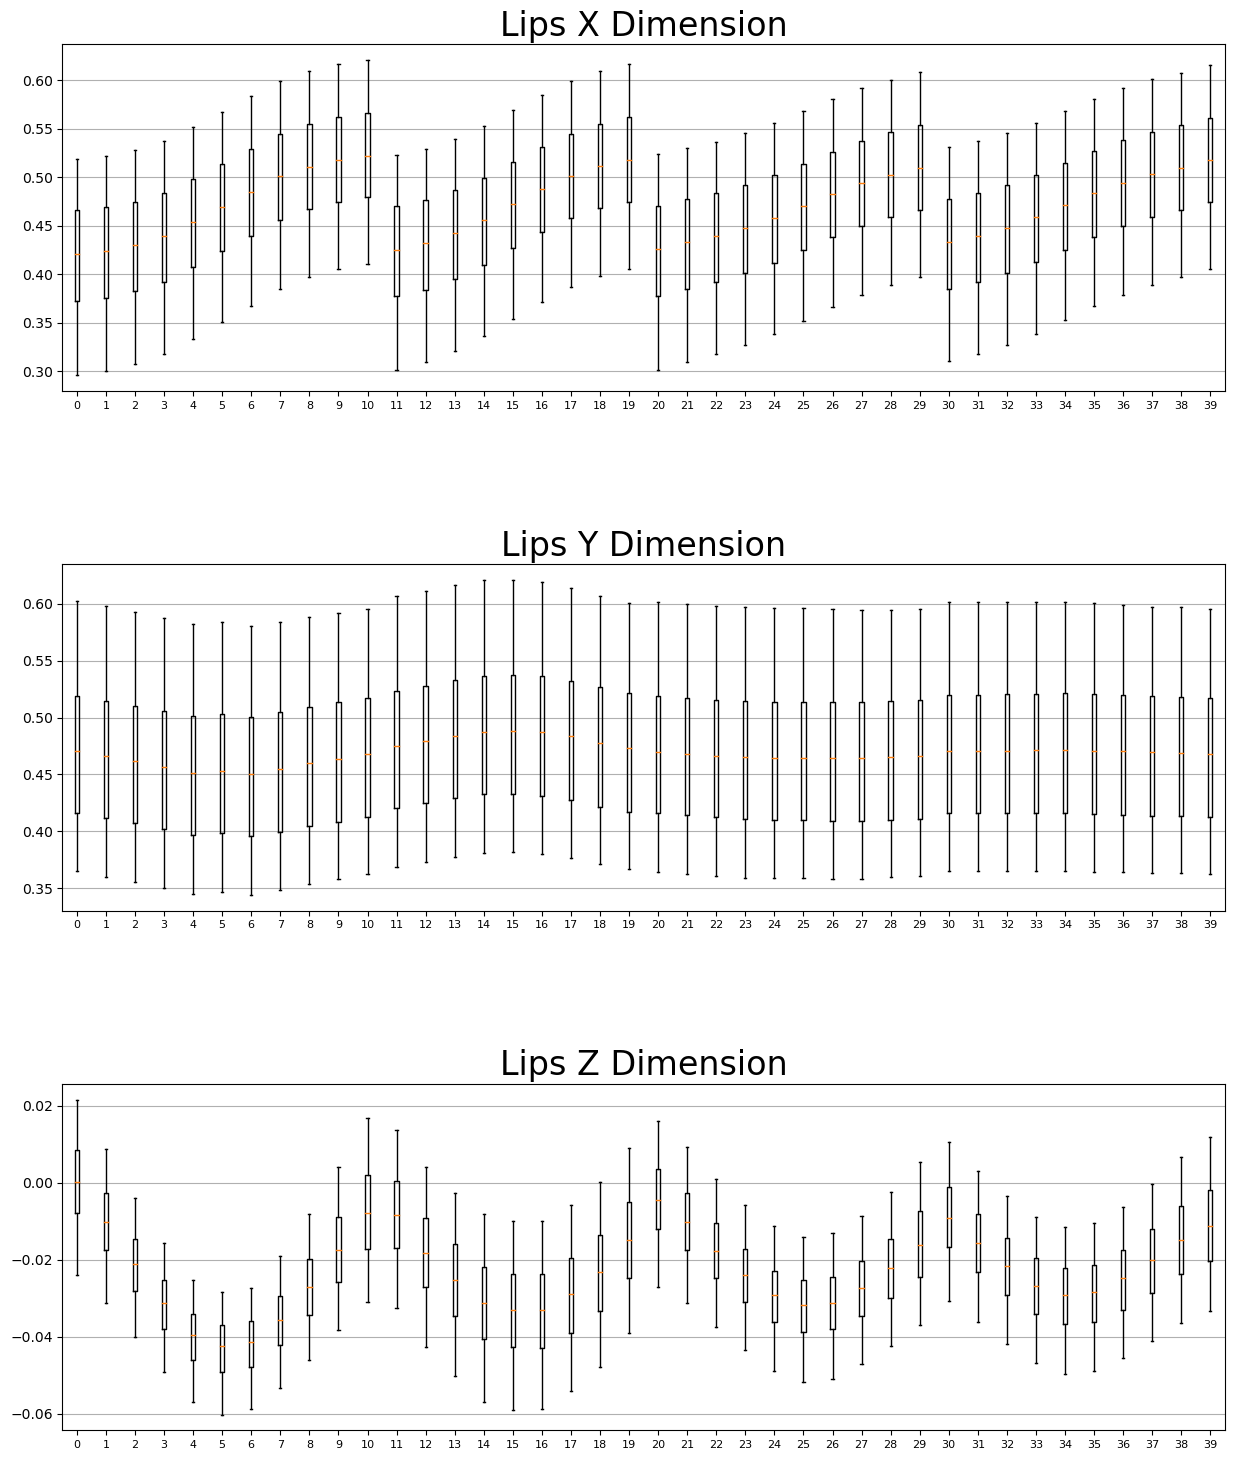

In [43]:

# LIPS
LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))
   
for col, ll in enumerate(tqdm( np.transpose(X[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            LIPS_MEAN_X[col] = v.mean()
            LIPS_STD_X[col] = v.std()
        if dim == 1: # Y
            LIPS_MEAN_Y[col] = v.mean()
            LIPS_STD_Y[col] = v.std()
        
        axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
for ax, dim_name in zip(axes, DIM_NAMES):
    ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y')

plt.subplots_adjust(hspace=0.50)
plt.show()

LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

## Hands

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.29it/s]


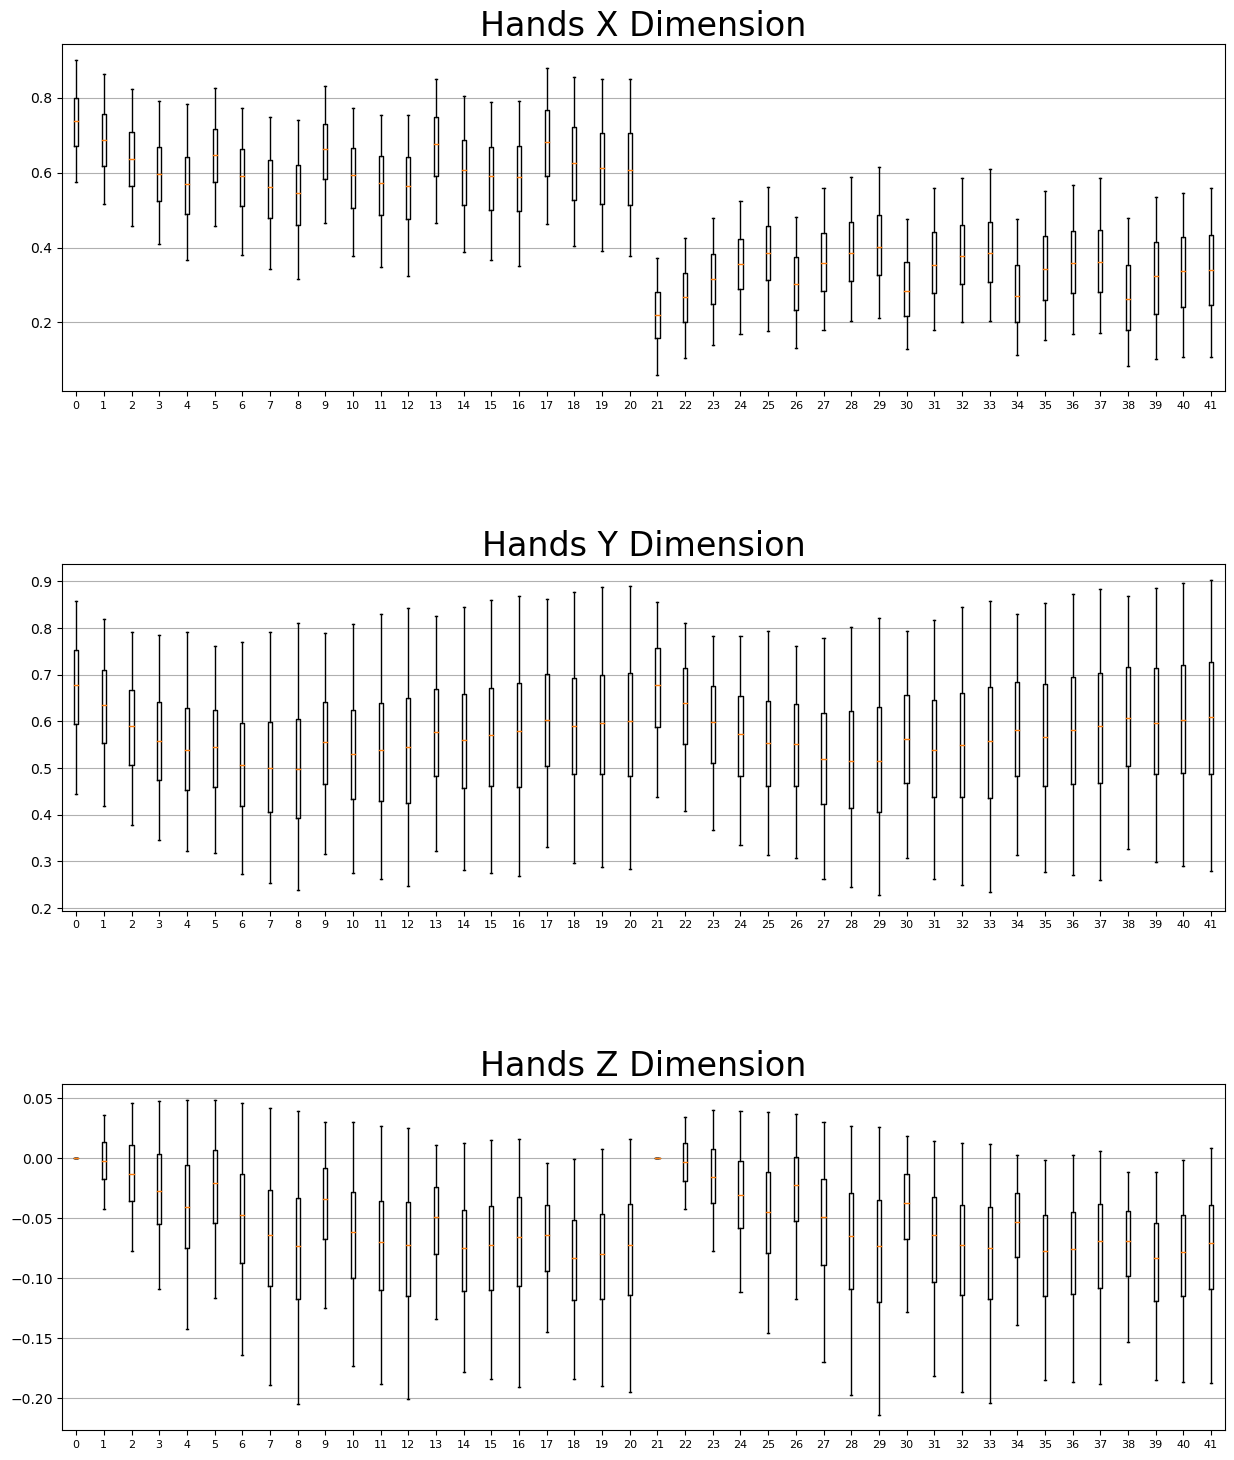

In [44]:
# LEFT HAND
LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# RIGHT HAND
RIGHT_HANDS_MEAN_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_MEAN_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)

fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))
   
for col, ll in enumerate(tqdm( np.transpose(X[:,:,HAND_IDXS], [2,3,0,1]).reshape([HAND_IDXS.size, N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            else:
                RIGHT_HANDS_MEAN_X[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_X[col - LEFT_HAND_IDXS.size] = v.std()
        if dim == 1: # Y
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            else: # RIGHT HAND
                RIGHT_HANDS_MEAN_Y[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_Y[col - LEFT_HAND_IDXS.size] = v.std()
        
        axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
for ax, dim_name in zip(axes, DIM_NAMES):
    ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y')

plt.subplots_adjust(hspace=0.50)
plt.show()

LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
RIGHT_HANDS_MEAN = np.array([RIGHT_HANDS_MEAN_X, RIGHT_HANDS_MEAN_Y]).T
RIGHT_HANDS_STD = np.array([RIGHT_HANDS_STD_X, RIGHT_HANDS_STD_Y]).T

## POSE

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


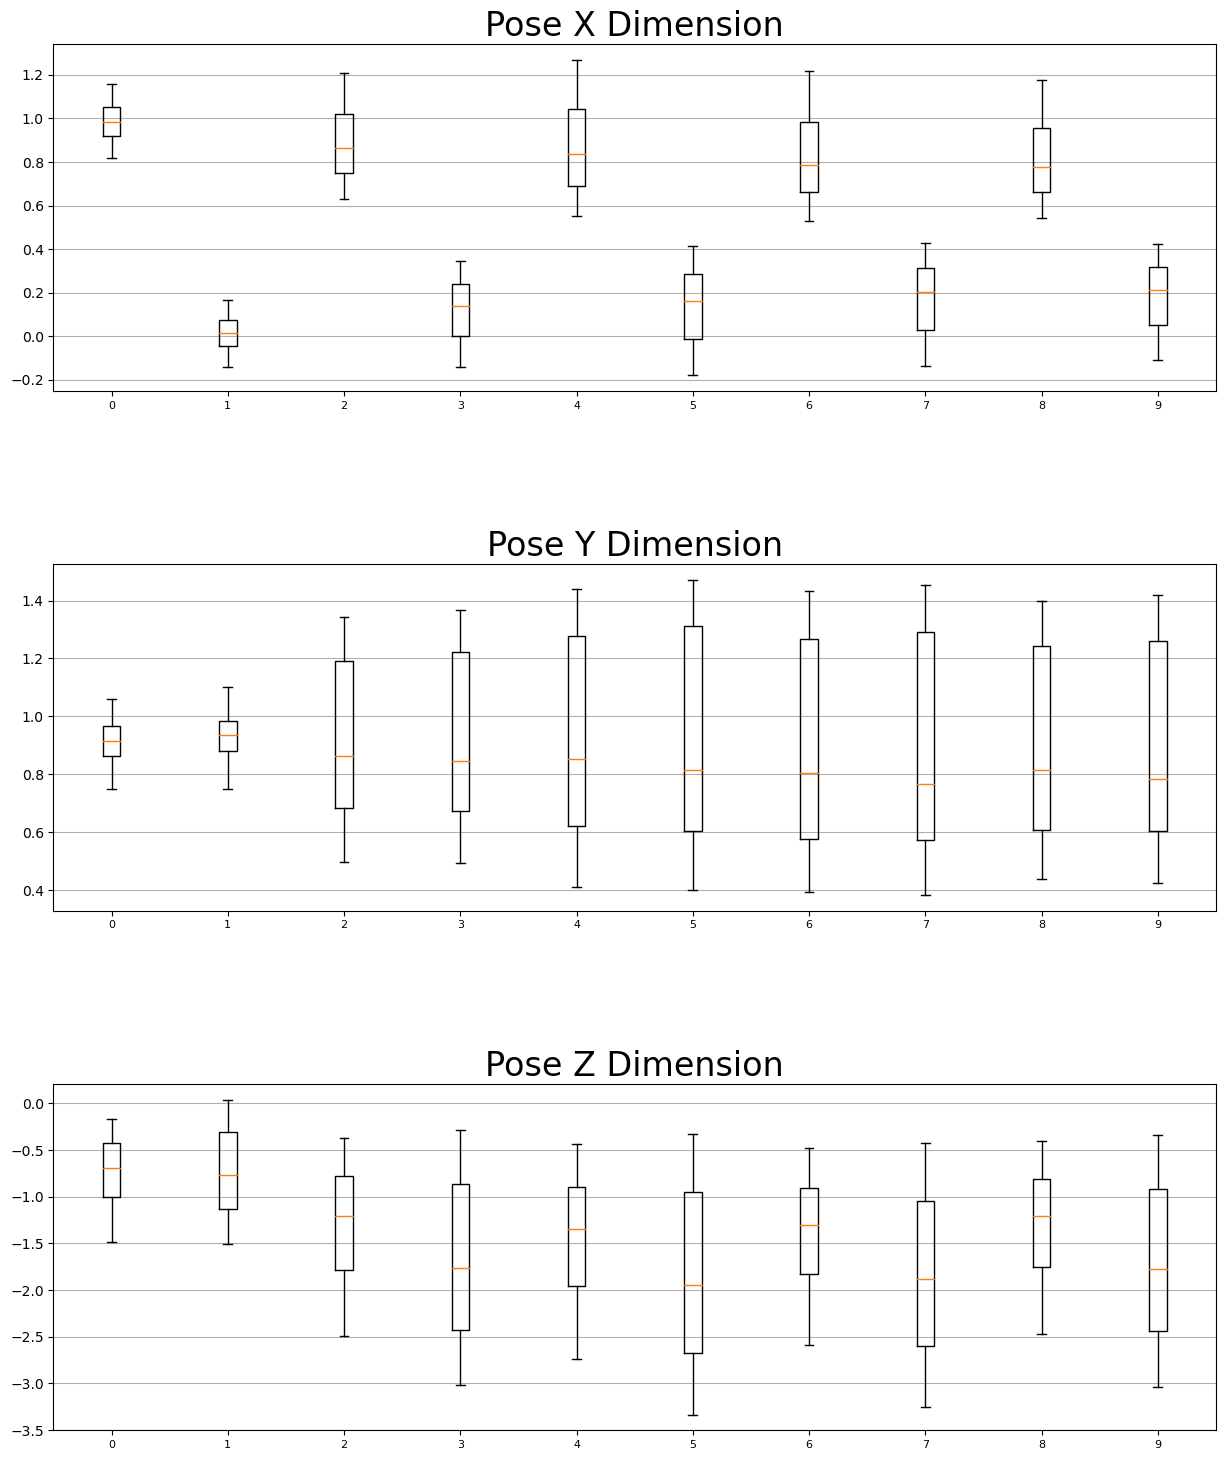

In [45]:
# POSE
POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))
   
for col, ll in enumerate(tqdm( np.transpose(X[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            POSE_MEAN_X[col] = v.mean()
            POSE_STD_X[col] = v.std()
        if dim == 1: # Y
            POSE_MEAN_Y[col] = v.mean()
            POSE_STD_Y[col] = v.std()
        
        axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
for ax, dim_name in zip(axes, DIM_NAMES):
    ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
    ax.tick_params(axis='x', labelsize=8)
    ax.grid(axis='y')

plt.subplots_adjust(hspace=0.50)
plt.show()

POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

# Landmark Embedding

In [46]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=True, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=True, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

## Embedding

In [47]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        self.positional_weight = tf.Variable(1.)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.right_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'right_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([4], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, right_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((lips_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_weight*self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [48]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
           tf.math.equal(lips, 0.0),
          0.0,
           (lips - LIPS_MEAN) / LIPS_STD,
      )
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    # RIGHT HAND
    right_hand = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 21, 2])
    right_hand = tf.where(
            tf.math.equal(right_hand, 0.0),
            0.0,
            (right_hand - RIGHT_HANDS_MEAN) / RIGHT_HANDS_STD,
        )
    right_hand = tf.reshape(right_hand, [-1, INPUT_SIZE, 21*2])
    # POSE
    pose = tf.slice(x, [0,0,82,0], [-1,INPUT_SIZE, 10, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 10*2])
    
    x = lips, left_hand, right_hand, pose
        
    x = Embedding()(lips, left_hand, right_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [49]:
tf.keras.backend.clear_session()

model = get_model()

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 32, 92, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 32, 92, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 32, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 32, 21, 2)    0           ['tf.slice[0][0]']               
                                                                                              

# Lr-Scheduler

In [51]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

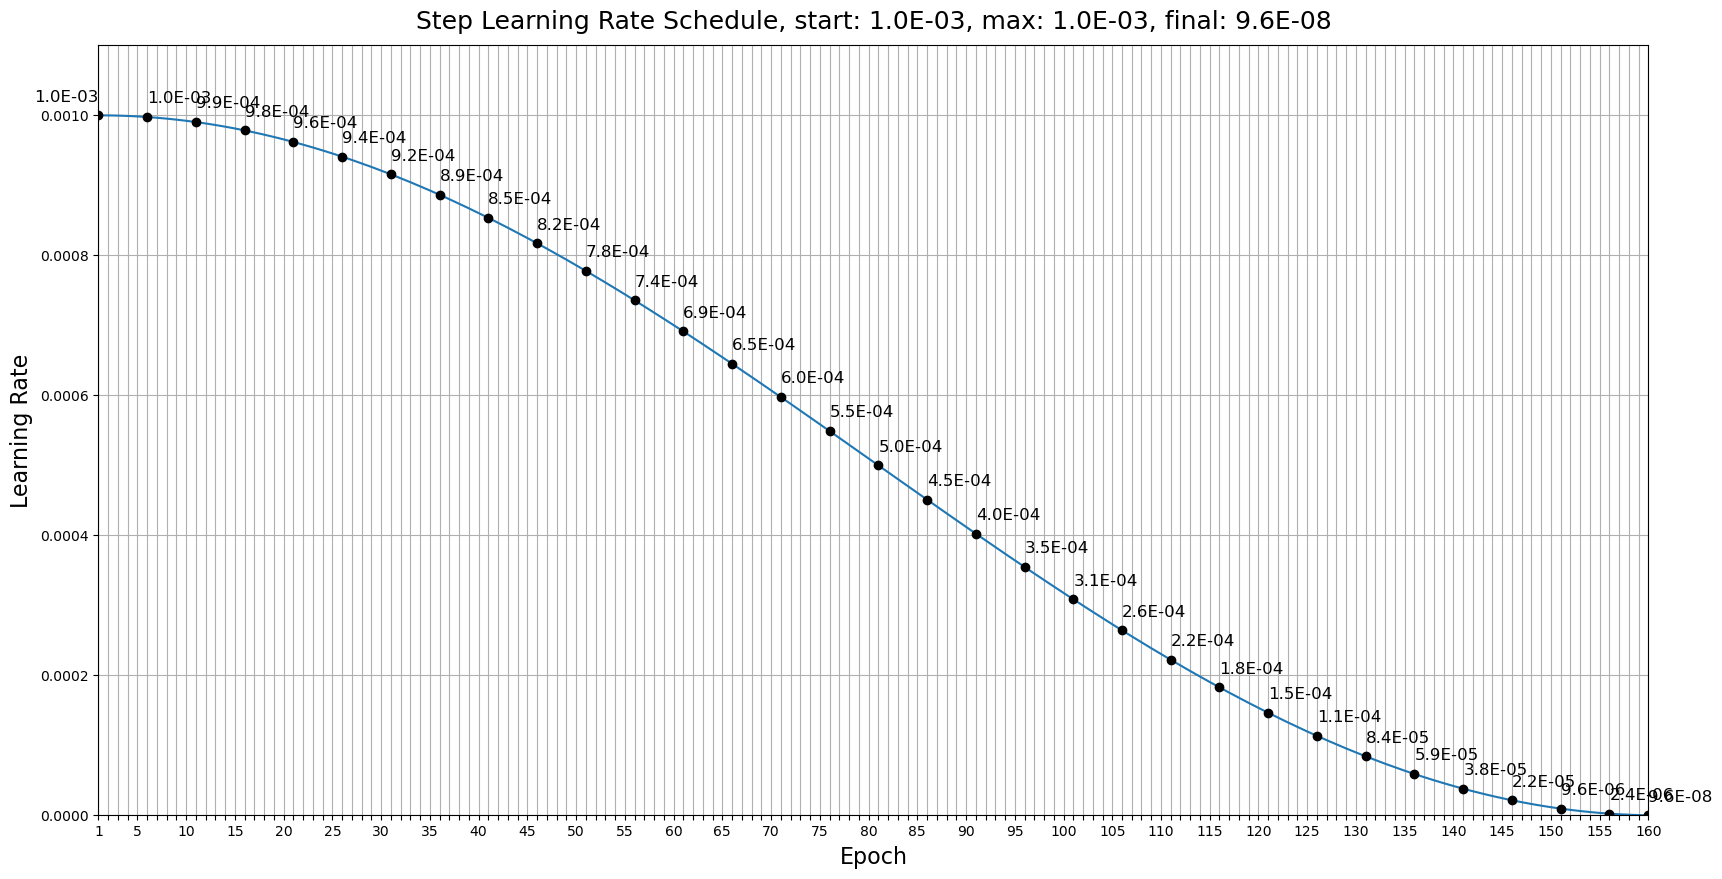

In [52]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Callbacks

In [53]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Model Training

In [54]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X[:1], 'non_empty_frame_idxs': Non_empty_Frame_idxs[:1] })
    pass

36.8 ms ± 8.68 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X, y, Non_empty_Frame_idxs),
            steps_per_epoch=len(X) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            #validation_data=({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val),
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = 1,
        )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 32, 92, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 32, 92, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 32, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 32, 21, 2)    0           ['tf.slice[0][0]']               
                                                                                              

# Create TF-Lite Model

In [ ]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)




In [ ]:
idx_to_predict = np.random.randint(low=0,high=len(df_train))

# Sanity Check
demo_raw_data = load_relevant_data_subset(df_train.iloc[idx_to_predict]['file_path'])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {df_train.iloc[idx_to_predict]["target"]}')

In [ ]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
tflite_model_file = os.path.join(ROOT_PATH,MODEL_DIR,"BL_Transformer_tf.tflite")
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)
    

# Test the TF-Lite Model

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tf_mod = fid.read()
    

In [ ]:
from tensorflow.lite.python.interpreter import Interpreter

In [ ]:
interpreter = Interpreter(tflite_model_file)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", label_dict_inv[sign], f'[{sign}]')
print("TRUE : ", df_train.iloc[idx_to_predict].sign, f'[{df_train.iloc[idx_to_predict].target}]')

In [ ]:
sign

NameError: name 'tf' is not defined